# Matter-Antimatter asymmetries at the LHC


Author: Arnau Duran Mayol, James McCusker

2022 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [2]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from scipy.stats import crystalball


### Input data
This opens input data files and assigns them to variables.

In [3]:
path = '../shared/' # set this to '' to run on the GitHub version
events_sim = uproot.open('PhaseSpaceSimulation.root')
events_down = uproot.open('B2HHH_MagnetDown.root')
events_up = uproot.open('B2HHH_MagnetUp.root')
M0_pion = 139.57039 #MeV
M0_pion_error = 0.00018 #MeV
M0_kaon = 493.677 #MeV
M0_kaon_error = 0.016 #MeV

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [4]:
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
probK = []
probPi = []
p = []
M_i = []
M = []
M_i_H12 = []
M_i_H13 = []
M_i_H23 = []
muon=[]
M_i_neg = []
M_i_pos = []
M_low = []
M_high = []
M_low_p = []
M_high_p = []
M_low_n = []
M_high_n = []
M_local_high_p = []
M_local_low_p = []
M_local_high_n = []
M_local_low_n = []
M_invariant_local_p = []
M_invariant_local_n = []

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events.
# It is recommended to keep the number of events limited while developing the analysis.
MAX_EVENTS = -1

# Select which set of input data is to be analysed. Uncomment exactly one line
#trees = [events_sim['PhaseSpaceTree']]                       # Simulation
#trees = [events_down[b'DecayTree']]                          # Magnet down data
#trees = [events_up['DecayTree']]                             # Magnet up data
trees = [events_down[b'DecayTree'],events_up['DecayTree']]   # Magnet down+up data
# This loop goes over the trees to be analysed
for tree in trees:
    # This outer loop is a technical loop of uproot over chunks of events
    for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
        # As Python can handle calculations with arrays, we can calculate derived quantities here
        pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
        pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
        pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)

        # Your invariant mass calculation should go here
        p_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2)
        p_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2)
        p_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2)
       
        P_X = data[b'H1_PX'] + data[b'H2_PX'] + data[b'H3_PX']
        P_Y = data[b'H1_PY'] + data[b'H2_PY'] + data[b'H3_PY']
        P_Z = data[b'H1_PZ'] + data[b'H2_PZ'] + data[b'H3_PZ']
       
        E_H1 = np.sqrt(M0_pion**2 + p_H1**2)
        E_H2 = np.sqrt(M0_pion**2 + p_H2**2)
        E_H3 = np.sqrt(M0_pion**2 + p_H3**2)
        M_invariant = np.sqrt((E_H1 + E_H2 + E_H3)**2 - (P_X**2 + P_Y**2 + P_Z**2))

        # Two body invariant mass H1, H2
        P_X_H12 = data[b'H1_PX'] + data[b'H2_PX']
        P_Y_H12 = data[b'H1_PY'] + data[b'H2_PY']
        P_Z_H12 = data[b'H1_PZ'] + data[b'H2_PZ']
        M_invariant_H12 = np.sqrt((E_H1 + E_H2)**2 - (P_X_H12**2 + P_Y_H12**2 + P_Z_H12**2))*10**-3

        # Two body invariant mass H1, H3
        P_X_H13 = data[b'H1_PX'] + data[b'H3_PX']
        P_Y_H13 = data[b'H1_PY'] + data[b'H3_PY']
        P_Z_H13 = data[b'H1_PZ'] + data[b'H3_PZ']
        M_invariant_H13 = np.sqrt((E_H1 + E_H3)**2 - (P_X_H13**2 + P_Y_H13**2 + P_Z_H13**2))*10**-3


        # Two body invariant mass H2, H3
        P_X_H23 = data[b'H2_PX'] + data[b'H3_PX']
        P_Y_H23 = data[b'H2_PY'] + data[b'H3_PY']
        P_Z_H23 = data[b'H2_PZ'] + data[b'H3_PZ']
        M_invariant_H23 = np.sqrt((E_H2 + E_H3)**2 - (P_X_H23**2 + P_Y_H23**2 + P_Z_H23**2))*10**-3
       
        # This loop will go over individual events
        for i in range(0,len(data[b'H1_PZ'])):
            event_counter += 1
            if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
            if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
            # Decide here which events to analyse
            if (data[b'H1_PZ'][i] < 0) or (data[b'H2_PZ'][i] < 0) or (data[b'H3_PZ'][i] < 0): continue
            #if (data[b'H1_ProbPi'][i] < 0.8) or (data[b'H2_ProbPi'][i] < 0.8) or (data[b'H3_ProbPi'][i] < 0.8): continue
            if (data[b'H1_ProbPi'][i] * data[b'H2_ProbPi'][i] * data[b'H3_ProbPi'][i]) < 0.6: continue

            #if (data[b'H1_ProbK'][i] + data[b'H2_ProbK'][i] + data[b'H3_ProbK'][i]) > 0.2: continue

            if (data[b'H1_ProbK'][i] > 0.2) or (data[b'H2_ProbK'][i] > 0.2) or (data[b'H3_ProbK'][i] > 0.4): continue
            muon.append(data[b'H1_isMuon'][i])
            muon.append(data[b'H2_isMuon'][i])
            muon.append(data[b'H3_isMuon'][i])
            if (data[b'H1_isMuon'][i] > 0) or (data[b'H2_isMuon'][i] > 0) or (data[b'H3_isMuon'][i] > 0): continue
            # Fill arrays of events to be plotted and analysed further below
            # Adding values for all three hadrons to the same variable here
            pT.append(pT_H1[i])
            pT.append(pT_H2[i])
            pT.append(pT_H3[i])
            #pT.append(np.quantile(pT, 0.25))
            pX.append(data[b'H1_PX'][i])
            pX.append(data[b'H2_PX'][i])
            pX.append(data[b'H3_PX'][i])
            pY.append(data[b'H1_PY'][i])
            pY.append(data[b'H2_PY'][i])
            pY.append(data[b'H3_PY'][i])
            pZ.append(data[b'H1_PZ'][i])
            pZ.append(data[b'H2_PZ'][i])
            pZ.append(data[b'H3_PZ'][i])
           
            probK.append(data[b'H1_ProbK'][i])
            probPi.append(data[b'H1_ProbPi'][i])
            probK.append(data[b'H2_ProbK'][i])
            probPi.append(data[b'H2_ProbPi'][i])
            probK.append(data[b'H3_ProbK'][i])
            probPi.append(data[b'H3_ProbPi'][i])

            p.append(p_H1[i])
            p.append(p_H2[i])
            p.append(p_H3[i])
            M.append(M_invariant[i])
              
            if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) < 0:
                M_i_neg.append(M_invariant[i])
               
            if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) > 0:
                M_i_pos.append(M_invariant[i])
            if (1.850 < M_invariant_H12[i] < 1.885): continue
            if (1.850 < M_invariant_H13[i] < 1.885): continue
            if (1.760 < M_invariant_H12[i] < 1.800): continue
            if (1.760 < M_invariant_H13[i] < 1.800): continue
            sigma = 60
            minimum = 5283.83 - sigma
            maximum = 5283.83 + sigma
            #if (M_invariant[i]) < minimum: continue
            #if (M_invariant[i]) > maximum: continue
              
            M_i.append(M_invariant[i])   

            if (data[b'H1_Charge'][i]) +  (data[b'H2_Charge'][i]) == 0:
                M_i_H12.append(M_invariant_H12[i])
               
            if (data[b'H3_Charge'][i]) +  (data[b'H2_Charge'][i]) == 0:
                M_i_H23.append(M_invariant_H23[i])
               
            if (data[b'H3_Charge'][i]) +  (data[b'H1_Charge'][i]) == 0:

                M_i_H13.append(M_invariant_H13[i])

                
            if M_invariant_H12[i] > M_invariant_H13[i]:
                if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) < 0:
                    M_high_n.append(18.33 < M_invariant_H12[i]**2  < 20)
                    M_low_n.append(4 < M_invariant_H13[i]**2 < 8.25)
                if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) > 0:
                    M_high_p.append(18.33 < M_invariant_H12[i]**2 < 20)
                    M_low_p.append(4 < M_invariant_H13[i]**2 < 8.25)

                
            else:
                if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) < 0:      
                    M_low_n.append(4 < M_invariant_H12[i]**2 < 8.25)
                    M_high_n.append(18.33 < M_invariant_H13[i]**2 < 20)
                if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) > 0:
                    M_low_p.append(4 < M_invariant_H12[i]**2 < 8.25)
                    M_high_p.append(18.33 < M_invariant_H13[i]**2 < 20)
                
            if M_invariant_H12[i] > M_invariant_H13[i]:
                    M_high.append(M_invariant_H12[i]**2)
                    M_low.append(M_invariant_H13[i]**2)
                
            else:
                    M_low.append(M_invariant_H12[i]**2)
                    M_high.append(M_invariant_H13[i]**2)
            if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) < 0:
                M_invariant_local_n.append(M_invariant[i])
               
            if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) > 0:
                M_invariant_local_p.append(M_invariant[i])

print('Read {:d} events'.format(event_counter))

Input data variables:
[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']
Read 100000 events
Read 200000 events
Read 300000 events
Read 400000 events
Read 500000 events
Read 600000 events
Read 700000 events
Read 800000 events
Read 900000 events
Read 1000000 events
Read 1100000 events
Read 1200000 events
Read 1300000 events
Read 1400000 events
Read 1500000 events
Read 1600000 events
Read 1700000 events
Read 1800000 events
Read 1900000 events
Read 2000000 events
Read 2100000 events
Read 2200000 events
Read 2300000 events
Read 2400000 events
Read 2500000 events
Read 2600000 events
Read 2700000 events
Read 2800000 events
Read 2900000 events
Read 3000000 events
Read 3100000 events
Read 3200000 events
Read 330000

In [ ]:
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
probK = []
probPi = []
p = []
M = []
M_i_H12_b = []
M_i_H13_b = []
M_i_H23_b = []
muon=[]
M_i_neg_b = []
M_i_pos_b = []
M_low_b_n = []
M_high_b_n = []
M_low_b_p = []
M_high_b_p = []
M_low_b = []
M_high_b = []
M_b = []

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events.
# It is recommended to keep the number of events limited while developing the analysis.
MAX_EVENTS = -1

# Select which set of input data is to be analysed. Uncomment exactly one line
#trees = [events_sim['PhaseSpaceTree']]                       # Simulation
#trees = [events_down[b'DecayTree']]                          # Magnet down data
#trees = [events_up['DecayTree']]                             # Magnet up data
trees = [events_down[b'DecayTree'],events_up['DecayTree']]   # Magnet down+up data
# This loop goes over the trees to be analysed
for tree in trees:
    # This outer loop is a technical loop of uproot over chunks of events
    for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
        # As Python can handle calculations with arrays, we can calculate derived quantities here
        pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
        pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
        pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)

        # Your invariant mass calculation should go here
        p_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2)
        p_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2)
        p_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2)
       
        P_X = data[b'H1_PX'] + data[b'H2_PX'] + data[b'H3_PX']
        P_Y = data[b'H1_PY'] + data[b'H2_PY'] + data[b'H3_PY']
        P_Z = data[b'H1_PZ'] + data[b'H2_PZ'] + data[b'H3_PZ']
       
        E_H1 = np.sqrt(M0_pion**2 + p_H1**2)
        E_H2 = np.sqrt(M0_pion**2 + p_H2**2)
        E_H3 = np.sqrt(M0_pion**2 + p_H3**2)
        M_invariant_b = np.sqrt((E_H1 + E_H2 + E_H3)**2 - (P_X**2 + P_Y**2 + P_Z**2))

        # Two body invariant mass H1, H2
        P_X_H12 = data[b'H1_PX'] + data[b'H2_PX']
        P_Y_H12 = data[b'H1_PY'] + data[b'H2_PY']
        P_Z_H12 = data[b'H1_PZ'] + data[b'H2_PZ']
        M_invariant_H12_b = np.sqrt((E_H1 + E_H2)**2 - (P_X_H12**2 + P_Y_H12**2 + P_Z_H12**2))*10**-3

        # Two body invariant mass H1, H3
        P_X_H13 = data[b'H1_PX'] + data[b'H3_PX']
        P_Y_H13 = data[b'H1_PY'] + data[b'H3_PY']
        P_Z_H13 = data[b'H1_PZ'] + data[b'H3_PZ']
        M_invariant_H13_b = np.sqrt((E_H1 + E_H3)**2 - (P_X_H13**2 + P_Y_H13**2 + P_Z_H13**2))*10**-3


        # Two body invariant mass H2, H3
        P_X_H23 = data[b'H2_PX'] + data[b'H3_PX']
        P_Y_H23 = data[b'H2_PY'] + data[b'H3_PY']
        P_Z_H23 = data[b'H2_PZ'] + data[b'H3_PZ']
        M_invariant_H23_b = np.sqrt((E_H2 + E_H3)**2 - (P_X_H23**2 + P_Y_H23**2 + P_Z_H23**2))*10**-3
       
        # This loop will go over individual events
        for i in range(0,len(data[b'H1_PZ'])):
            event_counter += 1
            if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
            if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
            # Decide here which events to analyse
            if (data[b'H1_PZ'][i] < 0) or (data[b'H2_PZ'][i] < 0) or (data[b'H3_PZ'][i] < 0): continue
            #if (data[b'H1_ProbPi'][i] < 0.8) or (data[b'H2_ProbPi'][i] < 0.8) or (data[b'H3_ProbPi'][i] < 0.8): continue
            if (data[b'H1_ProbPi'][i] * data[b'H2_ProbPi'][i] * data[b'H3_ProbPi'][i]) < 0.6: continue

            #if (data[b'H1_ProbK'][i] + data[b'H2_ProbK'][i] + data[b'H3_ProbK'][i]) > 0.2: continue

            if (data[b'H1_ProbK'][i] > 0.2) or (data[b'H2_ProbK'][i] > 0.2) or (data[b'H3_ProbK'][i] > 0.4): continue
            muon.append(data[b'H1_isMuon'][i])
            muon.append(data[b'H2_isMuon'][i])
            muon.append(data[b'H3_isMuon'][i])
            if (data[b'H1_isMuon'][i] > 0) or (data[b'H2_isMuon'][i] > 0) or (data[b'H3_isMuon'][i] > 0): continue
            # Fill arrays of events to be plotted and analysed further below
            # Adding values for all three hadrons to the same variable here
            pT.append(pT_H1[i])
            pT.append(pT_H2[i])
            pT.append(pT_H3[i])
            #pT.append(np.quantile(pT, 0.25))
            pX.append(data[b'H1_PX'][i])
            pX.append(data[b'H2_PX'][i])
            pX.append(data[b'H3_PX'][i])
            pY.append(data[b'H1_PY'][i])
            pY.append(data[b'H2_PY'][i])
            pY.append(data[b'H3_PY'][i])
            pZ.append(data[b'H1_PZ'][i])
            pZ.append(data[b'H2_PZ'][i])
            pZ.append(data[b'H3_PZ'][i])
           
            probK.append(data[b'H1_ProbK'][i])
            probPi.append(data[b'H1_ProbPi'][i])
            probK.append(data[b'H2_ProbK'][i])
            probPi.append(data[b'H2_ProbPi'][i])
            probK.append(data[b'H3_ProbK'][i])
            probPi.append(data[b'H3_ProbPi'][i])

            p.append(p_H1[i])
            p.append(p_H2[i])
            p.append(p_H3[i])
              
            if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) < 0:
                M_i_neg_b.append(M_invariant_b[i])
               
            if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) > 0:
                M_i_pos_b.append(M_invariant_b[i])
            if (1.850 < M_invariant_H12_b[i] < 1.885): continue
            if (1.850 < M_invariant_H13_b[i] < 1.885): continue
            if (1.760 < M_invariant_H12_b[i] < 1.800): continue
            if (1.760 < M_invariant_H13_b[i] < 1.800): continue
            minimum = 5401.645
            maximum = 5600
            if (M_invariant_b[i]) < minimum: continue
            if (M_invariant_b[i]) > maximum: continue
            
            M_b.append(M_invariant_b[i])   

            if (data[b'H1_Charge'][i]) +  (data[b'H2_Charge'][i]) == 0:
                M_i_H12_b.append(M_invariant_H12_b[i])
               
            if (data[b'H3_Charge'][i]) +  (data[b'H2_Charge'][i]) == 0:
                M_i_H23_b.append(M_invariant_H23_b[i])
               
            if (data[b'H3_Charge'][i]) +  (data[b'H1_Charge'][i]) == 0:

                M_i_H13_b.append(M_invariant_H13_b[i])

            if M_invariant_H12_b[i] > M_invariant_H13_b[i]:
                if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) < 0:
                    M_high_b_n.append(M_invariant_H12_b[i]**2)
                    M_low_b_n.append(M_invariant_H13_b[i]**2)
                if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) > 0:
                    M_high_b_p.append(M_invariant_H12_b[i]**2)
                    M_low_b_p.append(M_invariant_H13_b[i]**2)

                
            else:
                if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) < 0:      
                    M_low_b_n.append(M_invariant_H12_b[i]**2)
                    M_high_b_n.append(M_invariant_H13_b[i]**2)
                if (data[b'H1_Charge'][i] + data[b'H2_Charge'][i] + data[b'H3_Charge'][i]) > 0:
                    M_low_b_p.append(M_invariant_H12_b[i]**2)
                    M_high_b_p.append(M_invariant_H13_b[i]**2)

            if M_invariant_H12_b[i] > M_invariant_H13_b[i]:
                    M_high_b.append(M_invariant_H12_b[i]**2)
                    M_low_b.append(M_invariant_H13_b[i]**2)

                
            else:
                    M_low_b.append(M_invariant_H12_b[i]**2)
                    M_high_b.append(M_invariant_H13_b[i]**2)

          
print('Read {:d} events'.format(event_counter))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

#Plots 1D histogram of the Pion and Kaon probabilties
h1 = ax[0].hist(probK, bins = 200, range = [0, 1],histtype='step',label='$probabilty Kaon$')
ax[0].hist(probPi, bins = 200, range = [0, 1],histtype='stepfilled',alpha=0.3,label='$probabilty Pion$')
ax[0].set_xlabel('Probability')
ax[0].set_ylabel('Entries')
ax[0].legend()
plt.savefig('probability.pdf')
#Plots 2D histogram comparing the two probabilitesf
h2d = ax[1].hist2d(probPi, probK, bins = [100,100], range = [[0,1],[0,1]],norm=colors.LogNorm())
ax[1].set_xlabel('ProbPi')
ax[1].set_ylabel('ProbK')
fig.colorbar(h2d[3],ax=ax[1])
plt.savefig('probability06-04.png', dpi=300)

### Invariant mass

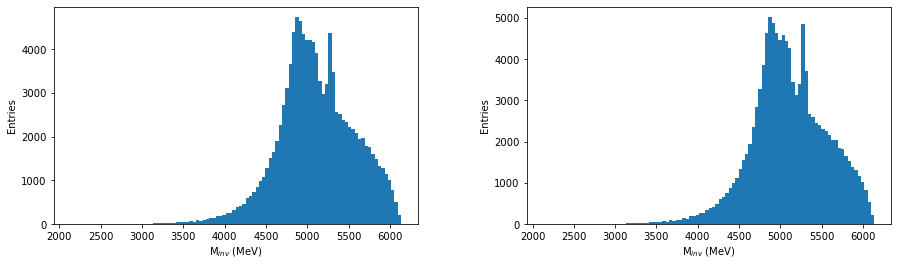

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
ax[0].hist(M_invariant_local_p, bins=100)#, range=[5200,5350])
ax[0].set_xlabel('M$_{inv}$ (MeV)')
ax[0].set_ylabel('Entries')
#plt.axvline(x=5279.34, color='r')
ax[1].hist(M_i_pos, bins=100)#, range=[5200,5350])
ax[1].set_xlabel('M$_{inv}$ (MeV)')
ax[1].set_ylabel('Entries')
#plt.savefig('mi_nomuon.png', dpi=300)
plt.show()


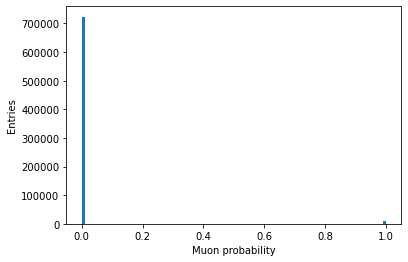

In [12]:
plt.hist(muon,100)
plt.xlabel('Muon probability')
plt.ylabel('Entries')
plt.show()


### Two body invarint mass

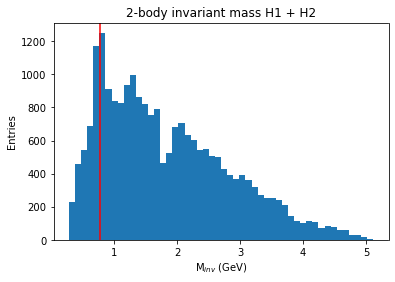

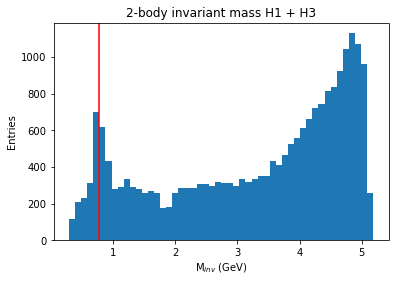

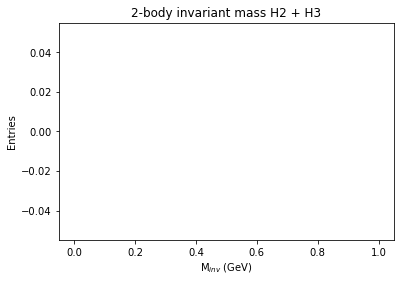

In [5]:
plt.hist(M_i_H12, bins=50)
plt.xlabel('M$_{inv}$ (GeV)')
plt.ylabel('Entries')
plt.axvline(x=0.770, color='r') #rho meson
plt.title('2-body invariant mass H1 + H2')
plt.savefig('H1_H2.png', dpi=300)
plt.show()

plt.hist(M_i_H13, bins=50)
plt.xlabel('M$_{inv}$ (GeV)')
plt.ylabel('Entries')
plt.axvline(x=0.770, color='r') #rho meson

plt.title('2-body invariant mass H1 + H3')
plt.savefig('H1_H3.png', dpi=300)
plt.show()

plt.hist(M_i_H23, bins=100)
plt.xlabel('M$_{inv}$ (GeV)')
plt.ylabel('Entries')
plt.title('2-body invariant mass H2 + H3')
#plt.savefig('mi_085_001.png', dpi=300)
plt.show()

## Dalitz Plots

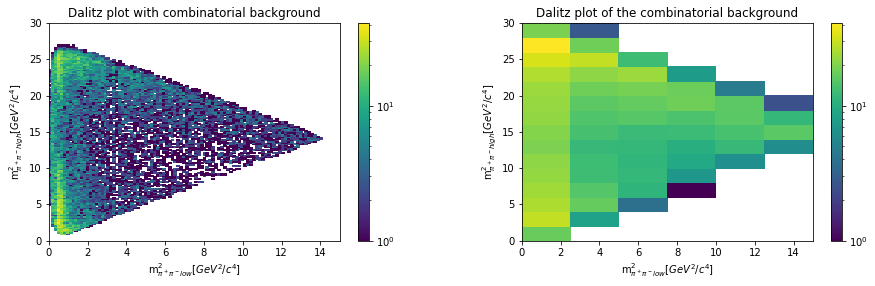

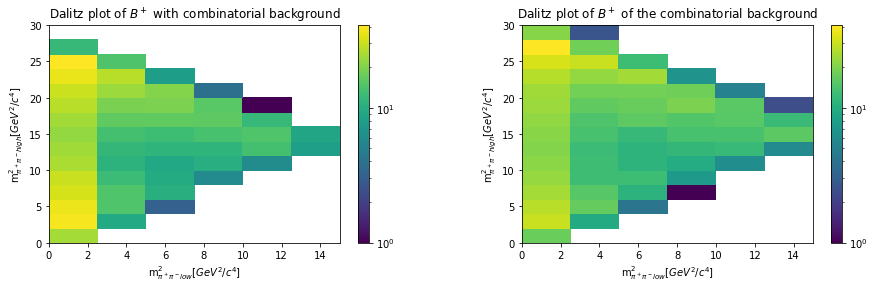

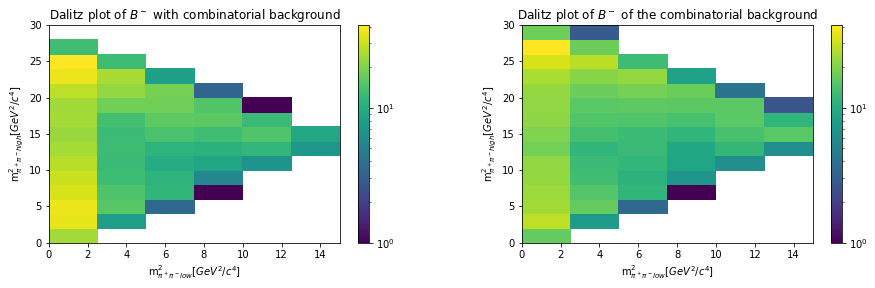

In [27]:
num_bins_x = 6
num_bins_y = 15
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
h2d1 = ax[0].hist2d(M_low, M_high, bins = [100,150], range = [[0, 15],[0, 30]], norm=colors.LogNorm())
ax[0].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[0].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[0].set_title('Dalitz plot with combinatorial background')
fig.colorbar(h2d1[3],ax=ax[0]) 
plt.savefig('dalitzplot.png', dpi=300)

h2d2 = ax[1].hist2d(M_low_b, M_high_b, bins = [num_bins_x,num_bins_y], range = [[0, 15],[0, 30]], norm=colors.LogNorm())
ax[1].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[1].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[1].set_title('Dalitz plot of the combinatorial background')
fig.colorbar(h2d1[3],ax=ax[1]) 
plt.savefig('new_dalitzplot.png', dpi=300)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
h2d3 = ax[0].hist2d(M_low_p, M_high_p, bins = [num_bins_x,num_bins_y], range = [[0, 15],[0, 30]], norm=colors.LogNorm())
ax[0].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[0].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[0].set_title('Dalitz plot of $B^+$ with combinatorial background')
fig.colorbar(h2d1[3],ax=ax[0]) 
#plt.savefig('dalitzplot.png', dpi=300)

h2d4 = ax[1].hist2d(M_low_b_p, M_high_b_p, bins = [num_bins_x,num_bins_y], range = [[0, 15],[0, 30]], norm=colors.LogNorm())
ax[1].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[1].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[1].set_title('Dalitz plot of $B^+$ of the combinatorial background')
fig.colorbar(h2d1[3],ax=ax[1]) 
#plt.savefig('new_dalitzplot.png', dpi=300)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
h2d5 = ax[0].hist2d(M_low_n, M_high_n, bins = [num_bins_x,num_bins_y], range = [[0, 15],[0, 30]], norm=colors.LogNorm())
ax[0].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[0].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[0].set_title('Dalitz plot of $B^-$ with combinatorial background')
fig.colorbar(h2d1[3],ax=ax[0]) 
#plt.savefig('dalitzplot.png', dpi=300)

h2d6 = ax[1].hist2d(M_low_b_n, M_high_b_n, bins = [num_bins_x,num_bins_y], range = [[0, 15],[0, 30]], norm=colors.LogNorm())
ax[1].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[1].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[1].set_title('Dalitz plot of $B^-$ of the combinatorial background')
fig.colorbar(h2d1[3],ax=ax[1]) 
plt.show()


## Dalitz Plot without combinatorial background

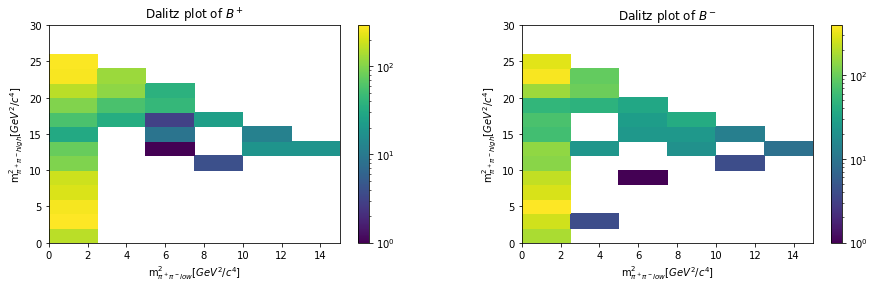

<ipython-input-13-7268fd55214f>:59: RuntimeWarning: invalid value encountered in true_divide
  local_asymmetry = (N_sub)/N_sum


In [13]:
# first calculate the bin centres from the bin boundaries of the hist2d object

xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )
xpos = []
ypos = []
for e,f in zip(h2d3[1][0:-1],h2d3[1][1:]):
    for g,h in zip(h2d3[2][0:-1],h2d3[2][1:]):
        xpos.append( (e+f)/2 )
        ypos.append( (g+h)/2 )
xneg = []
yneg = []
for i,j in zip(h2d5[1][0:-1],h2d5[1][1:]):
    for k,l in zip(h2d5[2][0:-1],h2d5[2][1:]):
        xneg.append( (i+j)/2 )
        yneg.append( (k+l)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
w3 = (np.array(h2d3[0])).flatten()
w4 = (np.array(h2d4[0])).flatten()
w5 = (np.array(h2d5[0])).flatten()
w6 = (np.array(h2d6[0])).flatten()
def substract(w1,w2):
    wsub = np.subtract(w1,w2) # subtract bin content of two histograms
    for i in range(len(wsub)):
        if wsub[i]<0:
            wsub[i] = 0
    return wsub
#TOTAL DALITZ PLOT
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
positivehist = ax[0].hist2d(xpos, ypos, weights=substract(w3,w4), bins = [num_bins_x,num_bins_y], range = [[0, 15],[0, 30]], norm=colors.LogNorm())
ax[0].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[0].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[0].set_title('Dalitz plot of $B^+$')
fig.colorbar(positivehist[3],ax=ax[0]) 

negativehist = ax[1].hist2d(xneg, yneg,weights=substract(w5,w6), bins = [num_bins_x,num_bins_y], range = [[0, 15],[0, 30]], norm=colors.LogNorm())
ax[1].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[1].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[1].set_title('Dalitz plot of $B^-$')
fig.colorbar(negativehist[3],ax=ax[1])
plt.savefig('Bdalitz.png', dpi=300)

plt.show()

#LOCAL ASYMMETRY DALITZ PLOT
N_plus = (np.array(positivehist[0])).flatten()
N_minus = (np.array(negativehist[0])).flatten()
N_sub = np.subtract(N_minus,N_plus)
N_sum = np.add(N_minus,N_plus)
#local_asymmetry = np.abs(N_sub[np.nonzero(N_sum)])/N_sum[np.nonzero(N_sum)]
local_asymmetry = (N_sub)/N_sum
local_asymmetry[np.isnan(local_asymmetry)]=0


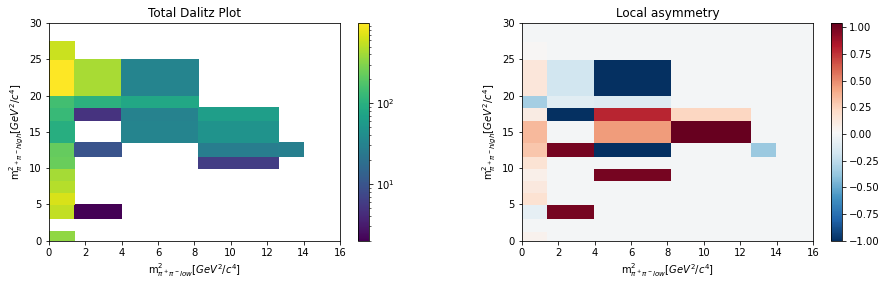

<ipython-input-23-ee630060b156>:23: RuntimeWarning: divide by zero encountered in true_divide
  A_error = np.sqrt((1-A**2)/(N + P))
<ipython-input-23-ee630060b156>:23: RuntimeWarning: invalid value encountered in true_divide
  A_error = np.sqrt((1-A**2)/(N + P))
<ipython-input-23-ee630060b156>:23: RuntimeWarning: invalid value encountered in sqrt
  A_error = np.sqrt((1-A**2)/(N + P))
<ipython-input-23-ee630060b156>:25: RuntimeWarning: divide by zero encountered in true_divide
  significance = (A / A_error)
<ipython-input-23-ee630060b156>:25: RuntimeWarning: invalid value encountered in true_divide
  significance = (A / A_error)


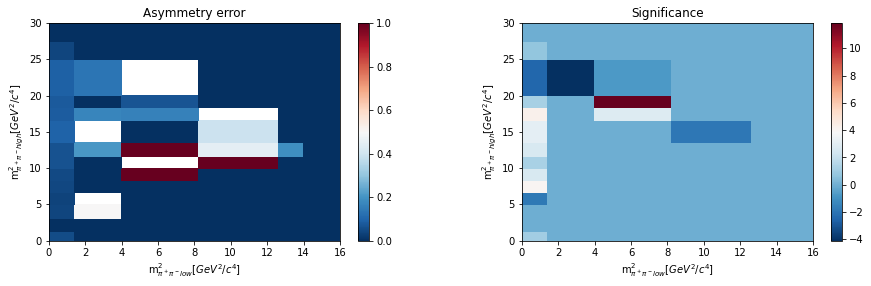

In [23]:
bin_x = (0. ,  1.4  , 4 ,   8.25 ,12.6 ,14., 16) # 6 bins
bin_y = ( 0.,1.25, 3 , 5,   6.66666667 , 8.33333333,
 10.,11.66666667, 13.5 ,16.5, 18.33333333,20, 25,27.5,28,30) # 15
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
total = ax[0].hist2d(xcentres,ycentres,weights=substract(w1,w2), bins = [bin_x,bin_y], norm=colors.LogNorm()) # recycle the binning from above
ax[0].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[0].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[0].set_title('Total Dalitz Plot')

fig.colorbar(total[3], ax=ax[0])

Asymmetry = ax[1].hist2d(xcentres,ycentres,weights=local_asymmetry, bins = [bin_x,bin_y], cmap='RdBu_r')# recycle the binning from above
ax[1].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[1].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[1].set_title('Local asymmetry')
fig.colorbar(Asymmetry[3], ax=ax[1])
plt.savefig('localasymmetry.png', dpi=300)
plt.show()
A = (np.array(Asymmetry[0])).flatten()
P = (np.array(positivehist[0])).flatten()
N = (np.array(negativehist[0])).flatten()
A_error = np.sqrt((1-A**2)/(N + P))
A_error[np.isinf(A_error)]=0
significance = (A / A_error)
significance[np.isinf(significance)]=0
significance[np.isnan(significance)]=0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
error = ax[0].hist2d(xcentres, ycentres, weights=A_error, bins=[bin_x,bin_y], range=[[0,15],[0,30]], cmap= 'RdBu_r')
ax[0].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[0].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[0].set_title('Asymmetry error')
fig.colorbar(error[3], ax=ax[0]) 

sig = ax[1].hist2d(xcentres, ycentres, weights=significance, bins=[bin_x,bin_y], range=[[0,15],[0,30]], cmap = 'RdBu_r')
ax[1].set_xlabel('m$^2_{\pi^+ \pi^- low} $[$GeV^2/c^4$]')
ax[1].set_ylabel('m$^2_{\pi^+ \pi^- high} $[$GeV^2/c^4$]')
ax[1].set_title('Significance')
fig.colorbar(sig[3], ax=ax[1])
plt.savefig('error_significance_dalitz.png', dpi=300)
plt.show()

### FIT

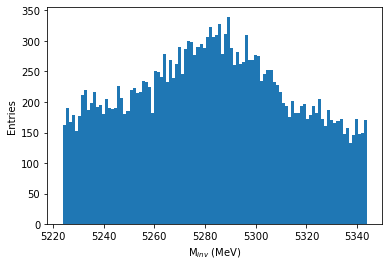

In [241]:
lower_bound = 5000
upper_bound = 5600
M_new = [d for d in M_i if lower_bound <= d <= upper_bound]

plt.hist(M_new, bins=100)
plt.xlabel('M$_{inv}$ (MeV)')
plt.ylabel('Entries')
plt.show()

# Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

Plotting 1D histogram
Plotting 2D histogram
Plotting 1D histogram
Plotting 2D histogram


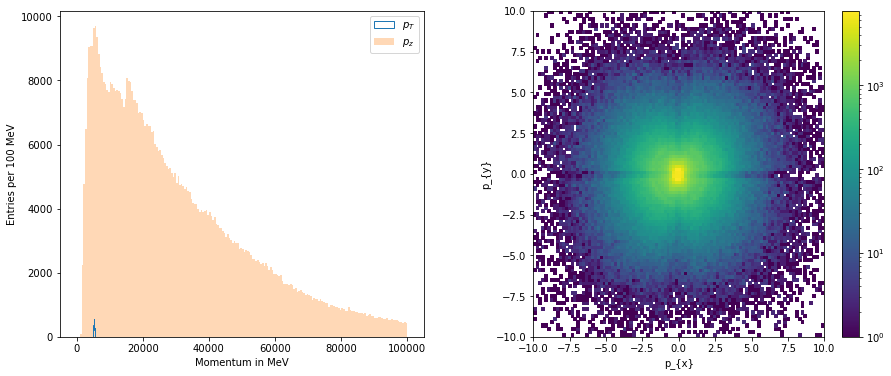

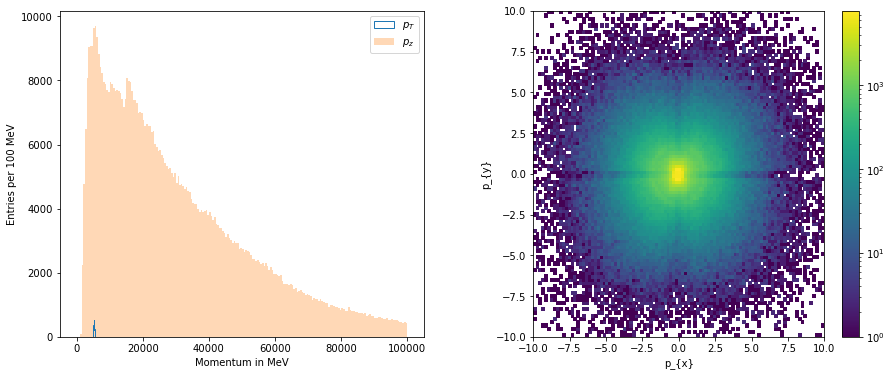

In [5]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(M_invariant_local_n, bins = 100, range = [5100, 5500],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('p_{x}')
ax[1].set_ylabel('p_{y}')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pos,bins_pos,patches_pos = ax[0].hist(M_invariant_local_p, bins = 100, range = [5100, 5500],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('p_{x}')
ax[1].set_ylabel('p_{y}')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

Fit results with chi2/ndf 118.07002354533554 / 100
Par 1: 39731.956449 +/- 20057.700179
Par 2: 1059.511778 +/- 106.037190
Par 3: 12803.528886 +/- 525.367082
Par 4: 5284.011615 +/- 0.736160
Par 5: 20.053895 +/- 0.808374
Par 6: 6160.888579 +/- 1216.694503
Par 7: 27.950836 +/- 4.394929
Fit results with chi2/ndf 110.7338760339337 / 100
Par 1: 31827.520986 +/- 16646.952840
Par 2: 1111.295802 +/- 120.592550
Par 3: 10846.940018 +/- 556.900426
Par 4: 5283.151372 +/- 0.924801
Par 5: 21.222054 +/- 1.038489
Par 6: 6487.896646 +/- 1368.118129
Par 7: 30.761091 +/- 4.910717
N- = 2553.8239223380892
N+ = 2044.465680154136


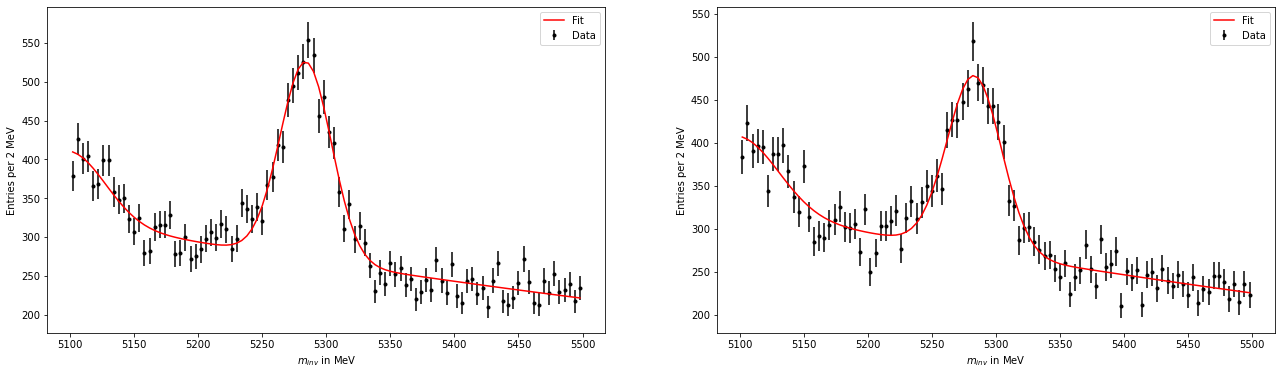

In [11]:
# decaying exponential function
def exponential(x, normE, decay):
    xoffset = 0 # this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array( normE * np.exp(-(x-xoffset)/decay) )

def gaussian(x,normG, mean, sigma):
    return normG * (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x - mean)**2/(2*sigma**2))


# constant function
def constant(x, norm):
    return np.array( norm )

# fit function combining two individual functions
def fit_function(x, normE, decay, normG, mean, sigma, normG2, sigma2):
    return np.array(exponential(x, normE, decay) + gaussian(x,normG, mean, sigma) + gaussian(x,normG2, 5100, sigma2))


def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays

    # reduce range to fit only part of curve
    bin_centres_red = []
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values as given in p0
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0) # fit
   
    # evaluate chi2
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2], coeff_fit[3],coeff_fit[4], coeff_fit[5], coeff_fit[6]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ),
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
   
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2], coeff_fit[3], coeff_fit[4], coeff_fit[5],  coeff_fit[6])
    a.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

    # plot decoration
    a.legend()
    a.set_xlabel('$m_{inv}$ in MeV')
    a.set_ylabel('Entries per 2 MeV')
    plt.savefig(fname)

coeff_pT,cov_pT, bin_centres_pT, bin_centres_red_pT, chi2_pT, ndf_pT = fit_data( bins_pT, values_pT, 5100, 5500, [300, 288667.89,381.572248,5279.34,19.696327,1300,42.47] )
coeff_pos,cov_pos, bin_centres_pos, bin_centres_red_pos, chi2_pos, ndf_pos = fit_data( bins_pos, values_pos, 5100, 5500, [300, 288667.89,381.572248,5279.34,19.696327,1300,42.47] )
bin_width = (5500-5100)/100
print_results(coeff_pT,cov_pT, chi2_pT, ndf_pT)
print_results(coeff_pos,cov_pos, chi2_pos, ndf_pos)
N_neg = coeff_pT[2]/(coeff_pT[4]/bin_width)
N_pos = coeff_pos[2]/(coeff_pos[4]/bin_width)
print('N- =',N_neg)
print('N+ =',N_pos)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))
plot_results(ax[0],bin_centres_pT,bin_centres_red_pT,values_pT,coeff_pT,'fit_pT.png')

plot_results(ax[1],bin_centres_pos,bin_centres_red_pos,values_pos,coeff_pos,'fit_pos.png')

## ASYMMETRY

In [12]:
A = ((N_neg-N_pos)/(N_neg+N_pos))
A_error = np.sqrt((1-A**2)/(N_neg+N_pos))
A_significance = A/A_error
print("Asymmetry=", A)
print("Error=",A_error)
print("Significance=",A_significance)

Asymmetry= 0.11077124022547133
Error= 0.014656183826910824
Significance= 7.557986549137006


### Manipulation of 2D histograms

The following is an example code to demonstrate manipulation of the content of 2D histograms. It first produces two dummy histograms before working out the bin centres, subtracting the histogram contents, and finally plotting. The subtraction bit can of course be replaced by more complex operations as well.

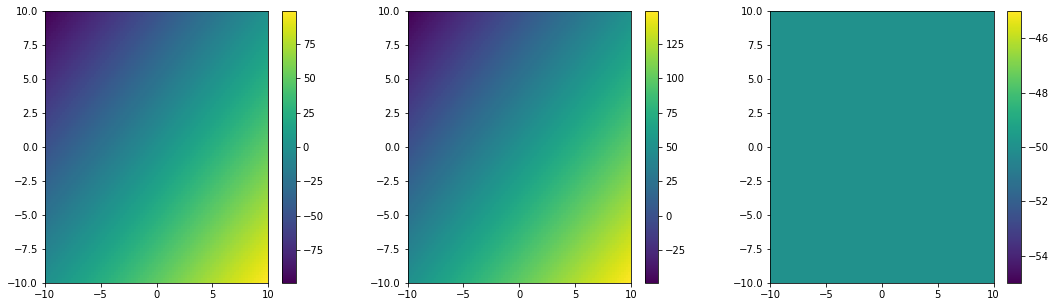

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

### ignore this bit and replace by however you produce your two 2D histograms to be subtracted ###
xvalues = []
yvalues = []
weights1 = []
weights2 = []
for x in range(100):
    for y in range(100):
        xvalues.append(-10+x/5.+0.1) # bin centre for x
        yvalues.append(-10+y/5.+0.1) # bin centre for y
        weights1.append((x-y))       # weights for histo1, this would be filled automatically
        weights2.append((x-y)+50)    # weights for histo2
h2d1 = ax[0].hist2d(xvalues,yvalues,weights=weights1,bins = [100,100], range = [[-10,10],[-10,10]])        
h2d2 = ax[1].hist2d(xvalues,yvalues,weights=weights2,bins = [100,100], range = [[-10,10],[-10,10]])
### end ignoring here :) ###

# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
h2d3 = ax[2].hist2d(xcentres,ycentres,weights=wsub, bins = [h2d1[1],h2d1[2]]) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0]) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1]) # let's add the colour scale for histo 2
fig.colorbar(h2d3[3],ax=ax[2]) # let's add the colour scale for histo 3